In [1]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

2026-01-19 20:40:58.014067: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-19 20:40:58.244927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-19 20:41:00.470553: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [ ]:
import tensorflow_datasets as tfds
ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0

    image = tf.image.rot90(image, k=3)
    image = tf.image.flip_left_right(image)

    image = tf.reshape(image, (28, 28, 1))

    return image, label

ds_train = ds_train.map(preprocess).batch(32)
ds_test = ds_test.map(preprocess).batch(32)

E0000 00:00:1768855262.741508   29756 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1768855262.752954   29756 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
x_train = []
y_train = []
for images, labels in tfds.as_numpy(ds_train):
    x_train.append(images)
    y_train.append(labels)

x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

x_test = []
y_test = []
for images, labels in tfds.as_numpy(ds_test):
    x_test.append(images)
    y_test.append(labels)

x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

2026-01-19 20:41:03.018739: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2026-01-19 20:41:05.117092: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-01-19 20:41:05.690234: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)


In [5]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=27)
y_train = y_train[:, 1:] 
y_test = tf.one_hot(y_test.astype(np.int32), depth=27)
y_test = y_test[:, 1:]

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)


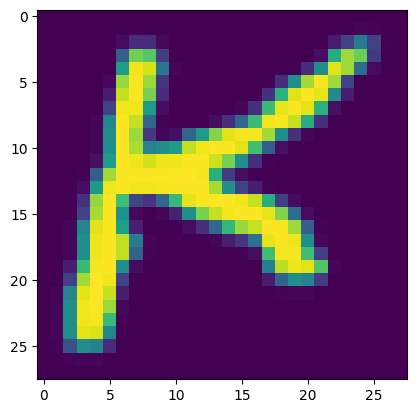

In [6]:
plt.imshow(x_train[3][:,:,0])
print(y_train[3])

In [7]:
batch_size = 32
num_classes = 26
epochs = 3

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(26, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

/home/cristaq/ocr/tensorflow-demo/tensorflow-demo/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/3
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - acc: 0.7573 - loss: 0.7971 - val_acc: 0.8993 - val_loss: 0.3151
Epoch 2/3
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - acc: 0.8610 - loss: 0.4397 - val_acc: 0.9186 - val_loss: 0.2603
Epoch 3/3
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - acc: 0.8839 - loss: 0.3602 - val_acc: 0.9224 - val_loss: 0.2583


In [ ]:
characters_dir = "characters"
files = sorted(
    os.listdir(characters_dir),
    key=lambda x: int(os.path.splitext(x)[0])
)

images = [
    Image.open(os.path.join(characters_dir, f)).convert('L')
    for f in files
]

for img in images:
    img = img.resize((28, 28))
    img_array = np.array(img)
    img_array = 255 - img_array
    img_array = img_array.reshape(1, 28, 28, 1)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    print(prediction)
    print(chr(np.argmax(prediction) + 65))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[[1.30801965e-07 1.43961515e-05 2.24013381e-14 9.99947906e-01
  2.32102757e-11 3.81453956e-13 1.37532474e-09 3.91539709e-12
  1.39991366e-10 3.49801462e-06 5.09012083e-15 2.95956003e-11
  7.28597836e-15 2.30678671e-10 2.46960026e-05 9.30439637e-06
  9.25090262e-08 1.14199130e-08 1.34382927e-09 2.77920076e-10
  2.56310244e-08 7.15437085e-11 6.58359312e-10 1.43572025e-12
  6.93862301e-10 1.00573763e-08]]
D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[5.1471807e-07 2.7456510e-08 3.8346373e-16 2.5193990e-14 3.9595108e-08
  3.9267606e-10 4.3628283e-08 6.7993883e-12 3.0375599e-15 5.1503876e-18
  5.4865079e-05 3.2565180e-13 3.6673384e-15 2.4135470e-14 7.8774243e-21
  6.3081388e-04 2.9118273e-06 9.9931085e-01 3.5380072e-20 4.2179246e-12
  1.4988547e-17 8.9104895e-17 5.2597090e-18 2.3555247e-10 1.7408566e-12
  1.5786921e-09]]
R
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[9.9597812e-01 3.8742387e-06 1.4352329e-10 2.0329491e-05 1.5575199e-07
  7.7577562e-07 5.9958425e